In [1]:
import sys
print(sys.version)

3.6.0 |Anaconda 4.3.1 (64-bit)| (default, Dec 23 2016, 11:57:41) [MSC v.1900 64 bit (AMD64)]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from gensim.models import Word2Vec

C:\Users\barte\Anaconda3\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [11]:
from sklearn.manifold import TSNE


#### Data loading

In [5]:
data = pd.read_csv("titles_books.csv")
data.sample(10)

,Unnamed: 0,title
15447,6691345883,Złodziej wrót. Orson S. Card (stan bdb)
34849,6841356003,H.P.LOVECRAFT - PRZYSZŁA NA SARNATH ZAGŁADA NOWA
26817,6817528058,Synowie Fenrisa. Cykl Warhammer 40000:... 48h
24437,6797876344,Opowieści z meekhańskiego pogranicza. Wschód Zac
3558,5605848320,Upadłe Anioły. Tom 1 Misja /J.r. Ward
2663,5305485202,"Za króla, ojczyznę i garść złota - Brzezińska ..."
8678,6343340001,Harry Potter Więzień + Czara Ognia Rowling fan...
19268,6747834145,Królestwo Słońca. Księga 1 część 2 - Bria
12203,6617271061,"ZAMEK ZŁUDZEŃ Lackey, Sherman / Opowieść Barda"
8085,6265056425,"Andre Norton, Świat Czarownic w pułapce"


In [26]:
import re
def getWords(text):
    splitted_text = text.split()
    new_splitted_text = []
    for item in splitted_text:
        if len(item) == 1:
            item = item.lower()
        new_splitted_text.append(item)
    new_text = " ".join(new_splitted_text)
    new_text = re.sub("\.", " ", new_text)
    new_text = re.sub("_", "", new_text)
    new_text = re.sub("(?<= [A-Z]{1}) +((?=[A-Z] )|(?=[A-Z]$))", "", new_text)
    all_words = re.compile('\w+').findall(new_text)
    return [words.lower() for words in all_words if len(words)>1]

In [27]:
titles = [getWords(title) for title in data.title]

#### Model training

In [29]:
VECTOR_DIM = 100

In [32]:
model = Word2Vec(titles, size=VECTOR_DIM, min_count=0)

In [33]:
model.similar_by_word(word="tolkien".lower(), topn=20)

[('silmarillion', 0.9974279999732971),
 ('hobbit', 0.9969028234481812),
 ('powrotem', 0.9908275604248047),
 ('skibniewska', 0.9892045259475708),
 ('beowulf', 0.9862571954727173),
 ('jrr', 0.9861257076263428),
 ('ósma', 0.9843853116035461),
 ('tol', 0.9842631220817566),
 ('pierścieni', 0.9842078685760498),
 ('tam', 0.9818210601806641),
 ('podlesia', 0.981387734413147),
 ('dżil', 0.981337308883667),
 ('władca', 0.981006920337677),
 ('pierścienia', 0.9810065031051636),
 ('piratów', 0.9802231192588806),
 ('sześciu', 0.9798630475997925),
 ('wladca', 0.9790375232696533),
 ('dwie', 0.9779176712036133),
 ('objaśnieniami', 0.9772122502326965),
 ('niedokończone', 0.9759489297866821)]

In [34]:
def get_word_score(model, word):
    try:
        score = model.wv[word]
    except:
        score = np.repeat(np.nan, repeats=VECTOR_DIM)
    return score

def get_title_score(model, title):
    title_parsed = getWords(title)
    mean_score = np.nanmean([get_word_score(model, i) for i in title_parsed], axis = 0) #nanmean to jak na.rm=TRUE w R
    return mean_score

In [35]:
v1 = get_title_score(model, "Tolkien - Władca pierścieni - Trylogia")
v2 = get_title_score(model, "NAUKA ŚWIATA DYSKU I - Terry Pratchett")
np.sum((v1-v2)**2)

91.910568

In [16]:
vectorized_titles = np.array([get_title_score(model, title) for title in data.title])

In [23]:
vectorized_titles_sample = vectorized_titles[np.random.choice(vectorized_titles.shape[0], size = 10000, replace=False)]

#### T-SNE visualizations

In [24]:
tsne_transformer = TSNE(verbose=1, perplexity=10)

In [25]:
tnsed_titles = tsne_transformer.fit_transform(vectorized_titles_sample)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000023
[t-SNE] KL divergence after 100 iterations with early exaggeration: 2.092148
[t-SNE] Error after 400 iterations: 2.092148


In [20]:
tnsed_titles

array([[-1.78095844, -1.03341117],
       [ 2.92423758,  2.01182427],
       [ 4.03744174, -0.41608314],
       ..., 
       [ 4.5018828 ,  0.49711014],
       [-4.89493819,  0.97082036],
       [-0.23756041,  5.28885968]])

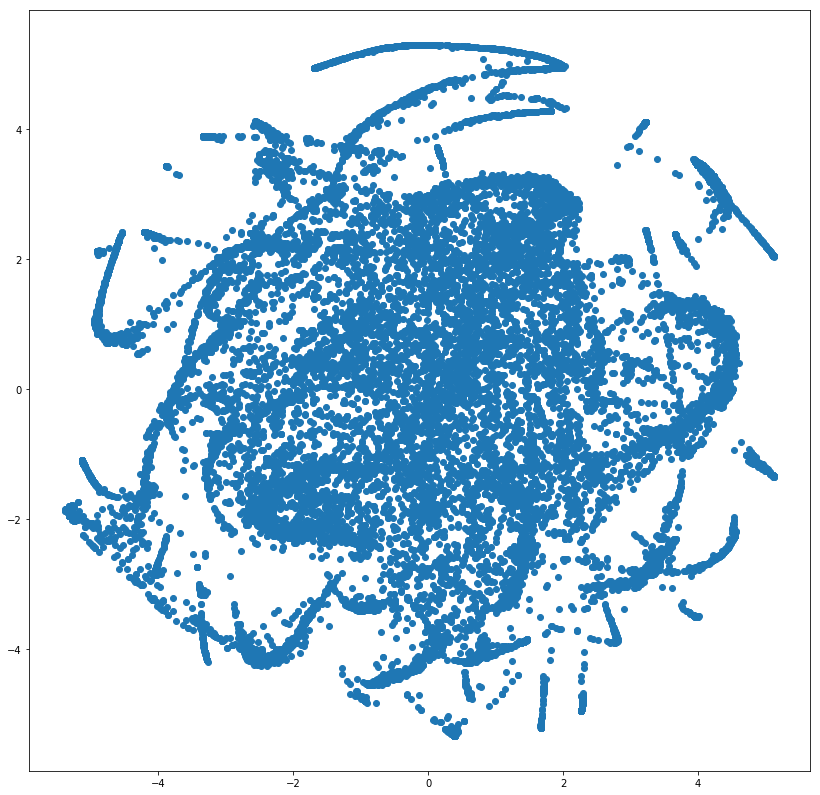

In [22]:
plt.figure(figsize=(14,14))
plt.scatter(tnsed_titles[:, 0], tnsed_titles[:, 1])
plt.show()